# Прогнозирование риска развития сердечно-сосудистого заболевания пациента
Задача с "Цифровой прорыв", Ярославль

### Условие задачи

Задача — разработать модель машинного обучения, цель которой — предсказание наличия сердечно-сосудистых заболеваний. Данные
содержат опрос реальных пациентов и их диагнозы, включая такие непрямые показатели, как образование, этнос, вид работы и многие другие.
В рамках чемпионата вам необходимо классифицировать
наличие/отсутствие у пациента следующих заболеваний:

● Артериальная гипертензия;

● Острое нарушение мозгового кровообращения;

● Стенокардия, ИБС, инфаркт миокарда;

● Сердечная недостаточность.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas_profiling
import datetime as dt
import time
from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, classification_report, f1_score
import seaborn as sns
from catboost import CatBoostClassifier

In [2]:
# расширенный вывод DataFrame
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Посмотрим как выглядят датасеты**

In [3]:
# исходный train
source_df = pd.read_csv('train.csv')
source_df.head(2)

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,NaN,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0


**Т.е. при получении сетки данных (test) необходимо спрогнозировать заболевания *['Артериальная гипертензия', 'ОНМК',
       'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
       'Прочие заболевания сердца']***

# Планирование:
* обрабатываем данные
* пробуем для каждой болезни свою модель (т.е. делаем из исходного DataFrame 5 отдельных)
* отбираем признаки (т.к. из всего многообразия для каждой модели может быть несколько ключевых признаков, а остальные - мусор. При чем для каждой модели будут свои значимые признаки)
* подбираем простейшие модели классификации (получается если сделать несколько моделей, то бинарная классификация)
* загружаем решение и смотрим на результат на публичном датасете на странице соревнования

# Идеи:
* т.к. заболевания могут быть одновременно, то можно попробовать несколько моделей (каждая модель для своего заболевания)
* посмотреть корреляцию болезней между собой (если они как-то связаны, то возможно по одной болезни можно еще и другую предсказать)
* если есть корреляция между болезнями, то можно еще и признаки, которые есть в train, но нет в test, использовать и для того, чтобы построить хорошую модель прогнозирования нескольких болезней, а уже на основе выявленной болезни добавлять к предсказанию другой болезни некоторую поправку

# Приступим к обработке и анализу данных

In [4]:
# профайл репор
# source_df.profile_report()

Название столбцов представленны в неудобном для вызовов формате, поэтому предлагается их сразу переименовать для удобства

In [5]:
source_df = source_df.rename(columns={'Вы работаете?': 'Трудоустройство',
                          'Выход на пенсию': 'Пенсия',
                          'Прекращение работы по болезни': 'Безработица_болезнь',
                          'Сахарный диабет': 'Диабет',
                          'Хроническое заболевание легких': 'Хроническое_заболевание_легких',
                          'Бронжиальная астма': 'Бронхиальная_астма',
                          'Туберкулез легких ': 'Туберкулез_легких', 
                          'ВИЧ/СПИД': 'ВИЧ_СПИД',
                          'Регулярный прим лекарственных средств': 'Прием_лекарств',
                          'Травмы за год': 'Травмы_год',
                          'Статус Курения': 'Статус_курения',
                          'Возраст курения': 'Возраст_курения', 
                          'Сигарет в день': 'Сигарет_в_день',
                          'Пассивное курение': 'Пассивное_курение', 
                          'Частота пасс кур': 'Частота_пасс_кур',
                          'Возраст алког': 'Возраст_алког',
                          'Время засыпания': 'Время_засыпания', 
                          'Время пробуждения': 'Время_пробуждения', 
                          'Сон после обеда': 'Послеобеденный_сон',
                          'Спорт, клубы': 'Спорт_клубы', 
                          'Религия, клубы': 'Религия_клубы',
                          'Артериальная гипертензия': 'Артериальная_гипертензия',
                          'Стенокардия, ИБС, инфаркт миокарда': 'Стенокардия_ИБС_инфаркт_миокарда',
                          'Сердечная недостаточность': 'Сердечная_недостаточность',
                          'Прочие заболевания сердца': 'Прочие_заболевания_сердца'})

In [6]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                955 non-null    object 
 1   Пол                               954 non-null    object 
 2   Семья                             955 non-null    object 
 3   Этнос                             955 non-null    object 
 4   Национальность                    955 non-null    object 
 5   Религия                           955 non-null    object 
 6   Образование                       955 non-null    object 
 7   Профессия                         955 non-null    object 
 8   Трудоустройство                   955 non-null    int64  
 9   Пенсия                            955 non-null    int64  
 10  Безработица_болезнь               955 non-null    int64  
 11  Диабет                            955 non-null    int64  
 12  Гепатит 

In [7]:
source_df.describe(include='all')

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,ID_y,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца
count,955,954,955,955,955,955,955,955,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000,955,412.000000,409.000000,955.000000,223,955,788.000000,955,955,955.000000,955.000000,955.000000,955,955.000000,955.000000,955.000000,955.000000,955.000000
unique,955,2,6,3,18,4,4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,5,3,NaN,22,34,NaN,NaN,NaN,955,NaN,NaN,NaN,NaN,NaN
top,54-102-358-02,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Никогда не курил(а),NaN,NaN,NaN,1-2 раза в неделю,употребляю в настоящее время,NaN,23:00:00,06:00:00,NaN,NaN,NaN,54-102-358-02,NaN,NaN,NaN,NaN,NaN
freq,1,667,563,931,899,804,454,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,543,NaN,NaN,NaN,92,634,NaN,311,233,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.523560,0.335079,0.048168,0.105759,0.120419,0.045026,0.075393,0.042932,0.020942,0.002094,0.642932,0.053403,0.353927,NaN,20.300971,14.220049,0.234555,NaN,NaN,20.038071,NaN,NaN,0.226178,0.068063,0.023037,NaN,0.467016,0.042932,0.122513,0.100524,0.090052
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.499706,0.472265,0.214232,0.307690,0.325621,0.207470,0.264162,0.202810,0.143267,0.045739,0.479386,0.224954,0.478437,NaN,8.039846,10.154710,0.423942,NaN,NaN,5.177517,NaN,NaN,0.418575,0.251986,0.150098,NaN,0.499172,0.202810,0.328049,0.300854,0.286407
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.000000,1.000000,0.000000,NaN,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,16.000000,6.000000,0.000000,NaN,NaN,17.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,18.000000,10.000000,0.000000,NaN,NaN,19.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,NaN,21.000000,20.000000,0.000000,NaN,NaN,20.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000


**Много пропущенных значений. Нужно разбираться в причинах - затем заполнять**
* н-р, возможно, что в возрасте курения стоит Nan, если человек не курит. Проверим это (если так, то поставим "0" вместо "None")
* аналогично со столбцом "Сигарет в день"

In [8]:
# уникальные статусы курения
source_df['Статус_курения'].unique()

array(['Курит', 'Никогда не курил(а)', 'Бросил(а)'], dtype=object)

In [9]:
# количество пропусков у курящих
source_df.query('Статус_курения == "Курит"')[['Возраст_курения']].isnull().sum()

Возраст_курения    0
dtype: int64

In [10]:
# количество пропусков у бросивших
source_df.query('Статус_курения == "Бросил(а)"')[['Возраст_курения']].isnull().sum()

Возраст_курения    0
dtype: int64

In [11]:
# количество пропусков у некурящих
source_df.query('Статус_курения == "Никогда не курил(а)"')[['Возраст_курения']].isnull().sum()

Возраст_курения    543
dtype: int64

**Как видим - пропущенные значения в графе "Возраст курения" только там, где люди не курили => можно заменить на "0"**

т.к. для прогнозирования не подойдет Nan

In [12]:
# замена пропусков на "0" в 'Возраст_курения'
source_df['Возраст_курения'].fillna(0, inplace=True)

In [13]:
# проверка на замену
source_df.query('Статус_курения == "Никогда не курил(а)"')['Возраст_курения'].unique()

array([0.])

**Аналогично проверим пропущенные значения по подгруппам Статуса курения - сигарет в день**

In [14]:
# количество пропусков у курящих
source_df.query('Статус_курения == "Курит"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    2
dtype: int64

In [15]:
# количество пропусков у бросивших
source_df.query('Статус_курения == "Бросил(а)"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    1
dtype: int64

In [16]:
# количество пропусков у некурящих
source_df.query('Статус_курения == "Никогда не курил(а)"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    543
dtype: int64

**"Сигарет в день" у Некурящих заменим на "0", а у "Курящих" и "Бросивших" - на среднее, взяв по одинаковому "Возраст курения" (если одинаковый возраст отсутствует, то возьмем среднее по ближайшим возрастам)**

У курящих:

In [17]:
source_df[(source_df['Статус_курения'] == "Курит") & source_df['Сигарет_в_день'].isna()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,ID_y,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца
354,54-601-015-02,М,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,"представители законодат. органов власти,...",0,0,0,0,0,0,0,0,0,0,0,0,1,Курит,25.0,NaN,0,NaN,употребляю в настоящее время,25.0,00:00:00,08:00:00,0,0,0,54-601-015-02,0,0,0,0,0
886,54-602-038-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,квалифицированные работники сельского хозяйств...,0,1,0,0,1,0,0,0,0,0,1,0,0,Курит,52.0,NaN,0,NaN,употребляю в настоящее время,26.0,22:00:00,06:00:00,0,0,0,54-602-038-01,1,1,0,0,1


In [18]:
# в среднем подгруппа ('Возраст_курения' == 25) выкуривает 9 сигарет в день. Заполним пропущенное значение данным средним  
fill = round(source_df[(source_df['Статус_курения'] == "Курит") & \
                       (source_df['Возраст_курения'] == 25)]['Сигарет_в_день'].mean())
print(fill)
source_df.loc[((source_df['Статус_курения'] == "Курит") & \
               (source_df['Возраст_курения'] == 25) & \
               source_df['Сигарет_в_день'].isna()), ('Сигарет_в_день')] = fill

9


*Т.к. с Возраст_курения == 52 всего 1 человек (и тот имеет Nan в графе Сигарет_в_день), то возьмем ближайший промежуток (н-р, от 45 до 59 Возраст_курения) и в нем усредним по Сигарет_в_день.*

In [19]:
fill = round(source_df[(source_df['Статус_курения'] == "Курит") & \
                       (source_df['Возраст_курения'] >= 45) & \
                       (source_df['Возраст_курения'] <= 57)]['Сигарет_в_день'].mean())

source_df.loc[((source_df['Статус_курения'] == "Курит") & \
               (source_df['Возраст_курения'] == 52)), ('Сигарет_в_день')] = fill

*У бросивших:*

In [20]:
source_df[(source_df['Статус_курения'] == "Бросил(а)") & source_df['Сигарет_в_день'].isna()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,ID_y,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца
123,54-102-244-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,0,1,0,0,0,0,0,0,0,0,1,0,0,Бросил(а),18.0,NaN,0,NaN,ранее употреблял,19.0,00:00:00,05:00:00,1,0,0,54-102-244-02,1,0,0,0,0


In [21]:
# усредним Сигарет_в_день у Возраст_курения == 18
fill = round(source_df.query('(Статус_курения == "Бросил(а)") and(Возраст_курения == 18)')['Сигарет_в_день'].mean())

source_df.loc[((source_df['Статус_курения'] == "Бросил(а)") & \
               (source_df['Возраст_курения'] == 18) & \
               source_df['Сигарет_в_день'].isna()), ('Сигарет_в_день')] = fill

*Наконец, некурящие:*

*Заполним пропуски нулями*

In [22]:
source_df.loc[((source_df['Статус_курения'] == "Никогда не курил(а)") & \
               source_df['Сигарет_в_день'].isna()), ('Сигарет_в_день')] = 0

**Аналогично пропускам с курением, можно сделать и с алкоголем (Возраст_алког более 100 пропусков)**

In [23]:
# уникальных значений Алкоголь
source_df['Алкоголь'].unique()

array(['употребляю в настоящее время', 'никогда не употреблял',
       'ранее употреблял'], dtype=object)

In [24]:
# количество пропусков у Возраст_алког, при Алкоголь == "употребляю в настоящее время"
source_df.query('Алкоголь == "употребляю в настоящее время"')['Возраст_алког'].isnull().sum()

2

In [25]:
# количество пропусков у Возраст_алког, при Алкоголь == "никогда не употреблял"
source_df.query('Алкоголь == "никогда не употреблял"')['Возраст_алког'].isnull().sum()

165

In [26]:
# количество пропусков у Возраст_алког, при Алкоголь == "ранее употреблял"
source_df.query('Алкоголь == "ранее употреблял"')['Возраст_алког'].isnull().sum()

0

*Пропуски у Возраст_алког при Алкоголь == "употребляю в настоящее время" заменим на:*

* у мужчины на среднее по Возраст_алког среди употребляющих в наст время (т.к. образование и религия, когда добавляем в критерий, особо не меняет)

* у женщины на среднее по Возраст_алког среди употребляющих в наст время (т.к. другие параметры тоже не сильно меняют значение)

*Пропуски у Возраст_алког при Алкоголь == "никогда не употреблял" заменим на 0*



In [27]:
source_df[['Алкоголь', 'Возраст_алког']].count()

Алкоголь         955
Возраст_алког    788
dtype: int64

In [28]:
source_df[(source_df['Алкоголь'] == "употребляю в настоящее время") & \
          source_df['Возраст_алког'].isna()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,ID_y,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца
451,54-102-238-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,5 - ВУЗ,дипломированные специалисты,1,0,0,0,0,0,0,0,0,0,0,0,1,Курит,18.0,4.0,0,NaN,употребляю в настоящее время,NaN,23:00:00,06:00:00,0,0,0,54-102-238-02,0,0,0,0,0
545,54-701-032-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,0,0,1,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),0.0,0.0,0,NaN,употребляю в настоящее время,NaN,22:00:00,06:30:00,1,0,0,54-701-032-01,1,0,0,0,0


In [29]:
fill_m = round(source_df[(source_df['Алкоголь'] == "употребляю в настоящее время") & \
          (source_df['Пол'] == 'М')]['Возраст_алког'].mean())
fill_f = round(source_df[(source_df['Алкоголь'] == "употребляю в настоящее время") & \
          (source_df['Пол'] == 'Ж')]['Возраст_алког'].mean())

source_df.loc[((source_df['Алкоголь'] == "употребляю в настоящее время") & \
               (source_df['Пол'] == 'М') & \
               source_df['Возраст_алког'].isna()), ('Возраст_алког')] = fill_m

source_df.loc[((source_df['Алкоголь'] == "употребляю в настоящее время") & \
               (source_df['Пол'] == 'Ж') & \
               source_df['Возраст_алког'].isna()), ('Возраст_алког')] = fill_f

In [30]:
source_df.loc[((source_df['Алкоголь'] == "никогда не употреблял") & \
          source_df['Возраст_алког'].isna()), ('Возраст_алког')] = 0

**осталось 2 колонки (пол - 1 чел, скорее всего проще удалить. И Частота_пасс_кур - тут всего 223 значения. Выведем на экран, посмотрим)**

In [31]:
# уникальные значения Частота_пасс_кур
source_df['Частота_пасс_кур'].unique()

array([nan, '1-2 раза в неделю', '3-6 раз в неделю',
       'не менее 1 раза в день', '4 и более раз в день',
       '2-3 раза в день'], dtype=object)

*Т.к. видим графу Пассивное_курение со значениями 0 и 1, то скорее всего Частота_пасс_кур пропущена только у тех, у кого Пассивное_курение == 0. Проверим эту гипотезу*

In [32]:
source_df[(source_df['Пассивное_курение'] == 1)]['Частота_пасс_кур'].isna().sum()

2

In [33]:
source_df[(source_df['Пассивное_курение'] == 0)]['Частота_пасс_кур'].isna().sum()

730

*Гипотеза подтвердилась. Пропущена Частота_пасс_кур в основном у Пассивное_курение == 0 (пропущенных значений = 730). Но есть два пропущенных значения Частота_пасс_кур у Пассивное_курение == 1, заполним их. Затем заполним нулями, у кого Пассивное_курение == 0*

In [34]:
source_df[(source_df['Пассивное_курение'] == 1) & source_df['Частота_пасс_кур'].isna()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,ID_y,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца
175,54-102-340-01,М,в разводе,европейская,Русские,Христианство,5 - ВУЗ,служащие,1,0,0,0,1,0,0,0,0,0,1,0,1,Бросил(а),17.0,7.0,1,NaN,употребляю в настоящее время,20.0,23:30:00,07:00:00,0,0,0,54-102-340-01,1,0,0,0,0
247,54-701-024-02,М,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,ведение домашнего хозяйства,0,0,1,1,0,1,0,0,0,0,1,0,0,Никогда не курил(а),0.0,0.0,1,NaN,ранее употреблял,22.0,22:00:00,07:00:00,1,0,0,54-701-024-02,1,0,0,0,0


*Особые взаимосвязи с Частота_пасс_кур выявлять ради 2х элементов не целесообразно, поэтому заменим их модальными значениями по Частота_пасс_кур среди их пола*

In [35]:
fill = str(source_df[(source_df['Пассивное_курение'] == 1)  & \
                     (source_df['Пол'] == 'М')]['Частота_пасс_кур'].mode()) \
                        .split('\n')[0].split('  ')[2]

print(fill)
source_df.loc[((source_df['Пассивное_курение'] == 1) & source_df['Частота_пасс_кур'].isna()), ('Частота_пасс_кур')] = fill

1-2 раза в неделю


*Теперь заменим оставшиеся пропущенные значения Частота_пасс_кур у тех, у кого Пассивное_курение == 0 на "0 раз в неделю" (это временно)*

In [36]:
source_df.loc[((source_df['Пассивное_курение'] == 0) & \
               source_df['Частота_пасс_кур'].isna()), ('Частота_пасс_кур')] = '0 раз в неделю'

*Обнаружен экземпляр, у которого пассивное курение == 0, но при этом частота пассивного курения == '3-6'. Соответственно, это опечатка, заменим  Частота_пасс_кур на 0 раз в неделю*

In [37]:
source_df.loc[((source_df['Пассивное_курение'] == 0) & \
               (source_df['Частота_пасс_кур'] != '0 раз в неделю')), ('Частота_пасс_кур')] = '0 раз в неделю'

*Еще 1 пропущенное значение в графе Пол. Его можно было бы предсказать и заместить, но для упрощения предлагается удалить. Затем еще раз выведем информацию по датасету*

In [38]:
source_df = source_df.drop(index = source_df[source_df['Пол'].isna()].index)

In [39]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 954
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                954 non-null    object 
 1   Пол                               954 non-null    object 
 2   Семья                             954 non-null    object 
 3   Этнос                             954 non-null    object 
 4   Национальность                    954 non-null    object 
 5   Религия                           954 non-null    object 
 6   Образование                       954 non-null    object 
 7   Профессия                         954 non-null    object 
 8   Трудоустройство                   954 non-null    int64  
 9   Пенсия                            954 non-null    int64  
 10  Безработица_болезнь               954 non-null    int64  
 11  Диабет                            954 non-null    int64  
 12  Гепатит 

**Далее будем избавляться от ненужных столбцов**
* ID и ID_y дублируются, поэтому один смело можно удалить (удалим обоих, т.к. не несут смысловой нагрузки на данном этапе)

In [40]:
source_df = source_df.drop(['ID', 'ID_y'], axis=1)

**Время пробуждения и Время засыпания по своей сути отражает количество часов сна. Можно пересчитать это в один столбец**

In [41]:
source_df['Сон_часов'] = (source_df['Время_пробуждения'].apply(lambda x: pd.to_datetime(x)) - \
 source_df['Время_засыпания'].apply(lambda x: pd.to_datetime(x))).apply(lambda x: x.seconds / 3600)

In [42]:
source_df['Сон_часов'].max()

19.0

In [43]:
source_df['Сон_часов'].min()

0.0

Максимальное количество часов сна == 19, что явный выброс, который может испортить статистику, поэтому следует посмотреть эту строчку поближе и удалить, если ничего не сделать другого

Минимальное - 0, т.е. либо человек лег и встал сразу (не спал), либо проспал сутки, следовательно, тоже выброс, удалим

In [44]:
# удалим min Сон_часов == 0
source_df = source_df.drop(index = source_df[source_df['Сон_часов'] == source_df['Сон_часов'].min()].index)

In [45]:
source_df[source_df['Сон_часов'] == source_df['Сон_часов'].max()]

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,Артериальная_гипертензия,ОНМК,Стенокардия_ИБС_инфаркт_миокарда,Сердечная_недостаточность,Прочие_заболевания_сердца,Сон_часов
525,М,в браке в настоящее время,"другая азиатская (Корея, Малайзия, Таиланд, Вь...",Татары,Нет,4 - профессиональное училище,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,0,0,1,Бросил(а),15.0,10.0,0,0 раз в неделю,ранее употреблял,15.0,12:00:00,07:00:00,0,0,0,1,0,0,0,0,19.0


Время_засыпания	12, пробуждения - 7. Можно предположить, что перепутали и вместо 00 (что тоже является 12) написали 12. Исправим на 00.

In [46]:
source_df.loc[(source_df['Сон_часов'] == source_df['Сон_часов'].max()), ('Время_засыпания')] = '00:00:00'
source_df.loc[(source_df['Сон_часов'] == source_df['Сон_часов'].max()), ('Сон_часов')] = 7.0

*Больше выбросов не обнаружено*

Признаки Этнос и Национальность сразу отбросим по той причине, что доминирующий класс слишком большой, а остальных крайне мало, Семья, Религия - пока тоже скинем, Образование и Профессия проверим после составления модели (вряд ли они будут как-то влиять) 

Пока что сделаем наиболее удобные и быстрые преобразования признаков, затем посмотрим на их влияние с помощью

In [47]:
# создадим DataFrame  с признаками
df = source_df.drop(['Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 
                     'Профессия', 'Время_засыпания', 'Время_пробуждения'], axis=1)

In [48]:
# преобразуем признаки Пол, Статус_курения и Алкоголь с помощью встроенной ф-ии Pandas  get_dummies()
df = pd.get_dummies(df, columns=['Пол'], drop_first=True)
df = pd.get_dummies(df, columns=['Статус_курения'])
df = pd.get_dummies(df, columns=['Алкоголь'])

*Преобразуем Частота_пасс_кур из строк в числа примерно посчитав количество пассивных курений в неделю, т.е. преобразуем согласно след. строкам:*
* '0 раз в неделю'         => 0
* '1-2 раза в неделю'      => 2
* '3-6 раз в неделю'       => 5
* 'не менее 1 раза в день' => 8
* '2-3 раза в день'        => 17
* '4 и более раз в день'   => 35

In [49]:
# Преобразуем Частота_пасс_кур
df = df.replace({'Частота_пасс_кур': {'0 раз в неделю': 0, '1-2 раза в неделю': 2,
                                      '3-6 раз в неделю': 5, 'не менее 1 раза в день': 8,
                                      '2-3 раза в день': 17, '4 и более раз в день': 35}})

*Соберем признаки в списки для удобства и дальнейшего использования (чтобы у train и test нумерация колонок совпадала с признаком. Иначе можем спутать колонки)*
* **features** - признаки модели
* **cell** - целевые переменные (таргеты/targets)

In [50]:
# признаки для модели
features = ['Пол_М', 'Трудоустройство', 'Пенсия', 'Безработица_болезнь', 'Диабет', 'Гепатит', 'Онкология', 
            'Хроническое_заболевание_легких', 'Бронхиальная_астма', 'Туберкулез_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 
            'Травмы_год', 'Переломы', 'Статус_курения_Бросил(а)', 'Статус_курения_Курит', 
            'Статус_курения_Никогда не курил(а)', 'Возраст_курения', 'Сигарет_в_день', 'Пассивное_курение', 
            'Частота_пасс_кур', 'Алкоголь_никогда не употреблял', 'Алкоголь_ранее употреблял', 
            'Алкоголь_употребляю в настоящее время', 
            'Возраст_алког', 'Послеобеденный_сон', 'Спорт_клубы', 'Религия_клубы', 'Сон_часов']

cell = ['Артериальная_гипертензия', 'ОНМК', 'Стенокардия_ИБС_инфаркт_миокарда', 'Сердечная_недостаточность', 
        'Прочие_заболевания_сердца'] 

In [51]:
df[features + cell].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 953 entries, 0 to 954
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Пол_М                                  953 non-null    uint8  
 1   Трудоустройство                        953 non-null    int64  
 2   Пенсия                                 953 non-null    int64  
 3   Безработица_болезнь                    953 non-null    int64  
 4   Диабет                                 953 non-null    int64  
 5   Гепатит                                953 non-null    int64  
 6   Онкология                              953 non-null    int64  
 7   Хроническое_заболевание_легких         953 non-null    int64  
 8   Бронхиальная_астма                     953 non-null    int64  
 9   Туберкулез_легких                      953 non-null    int64  
 10  ВИЧ_СПИД                               953 non-null    int64  
 11  Прием_

# Обработка тестового датасета

In [52]:
test_df = pd.read_csv('test_dataset_test.csv')
test_df.head(5)

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
0,54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1
1,54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0
2,54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,18.0,23:00:00,07:30:00,0,0,0
3,54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,0,0,1,0,0,0,0,0,0,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,22:00:00,06:00:00,0,0,0
4,54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,0,0,0,0,0,0,0,0,1,1,1,Курит,14.0,20.0,0,NaN,употребляю в настоящее время,19.0,22:00:00,06:00:00,0,0,0


In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     638 non-null    object 
 1   Пол                                    638 non-null    object 
 2   Семья                                  638 non-null    object 
 3   Этнос                                  638 non-null    object 
 4   Национальность                         638 non-null    object 
 5   Религия                                638 non-null    object 
 6   Образование                            638 non-null    object 
 7   Профессия                              638 non-null    object 
 8   Вы работаете?                          638 non-null    int64  
 9   Выход на пенсию                        638 non-null    int64  
 10  Прекращение работы по болезни          638 non-null    int64  
 11  Сахарн

In [54]:
test_df['Образование'].value_counts()

4 - профессиональное училище                         303
5 - ВУЗ                                              234
3 - средняя школа / закон.среднее / выше среднего     98
2 - начальная школа                                    3
Name: Образование, dtype: int64

**Все, что применялось для заполнения и очистки тренировочных данных, применим и для тестовых**

In [55]:
test_df = test_df.rename(columns={'Вы работаете?': 'Трудоустройство',
                                  'Выход на пенсию': 'Пенсия',
                                  'Прекращение работы по болезни': 'Безработица_болезнь',
                                  'Сахарный диабет': 'Диабет',
                                  'Хроническое заболевание легких': 'Хроническое_заболевание_легких',
                                  'Бронжиальная астма': 'Бронхиальная_астма',
                                  'Туберкулез легких ': 'Туберкулез_легких', 
                                  'ВИЧ/СПИД': 'ВИЧ_СПИД',
                                  'Регулярный прим лекарственных средств': 'Прием_лекарств',
                                  'Травмы за год': 'Травмы_год',
                                  'Статус Курения': 'Статус_курения',
                                  'Возраст курения': 'Возраст_курения', 
                                  'Сигарет в день': 'Сигарет_в_день',
                                  'Пассивное курение': 'Пассивное_курение', 
                                  'Частота пасс кур': 'Частота_пасс_кур',
                                  'Возраст алког': 'Возраст_алког',
                                  'Время засыпания': 'Время_засыпания', 
                                  'Время пробуждения': 'Время_пробуждения', 
                                  'Сон после обеда': 'Послеобеденный_сон',
                                  'Спорт, клубы': 'Спорт_клубы', 
                                  'Религия, клубы': 'Религия_клубы',
                                  'Артериальная гипертензия': 'Артериальная_гипертензия',
                                  'Стенокардия, ИБС, инфаркт миокарда': 'Стенокардия_ИБС_инфаркт_миокарда',
                                  'Сердечная недостаточность': 'Сердечная_недостаточность',
                                  'Прочие заболевания сердца': 'Прочие_заболевания_сердца'})

In [56]:
test_df.head(1)

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы
0,54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1


In [57]:
# т.к. одно значение не совсем корректно записано ('Никогда не курил') - заменим его на правильное
test_df.loc[test_df['Статус_курения'] == 'Никогда не курил', ('Статус_курения')] = 'Никогда не курил(а)'

In [58]:
# замена пропусков на "0" в 'Возраст_курения'
test_df['Возраст_курения'].fillna(0, inplace=True)

In [59]:
#
# проверка на замену
#test_df.query('Статус_курения == "Никогда не курил(а)"')['Возраст_курения'].unique()

In [60]:
# количество пропусков у курящих
test_df.query('Статус_курения == "Курит"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    1
dtype: int64

In [62]:
# замена пропущенного значения Сигарет_в_день у курящего (заменили на среднюю в ближайшей возрастной окрестности)
fill = round(round(source_df[(source_df['Возраст_курения'] >= 7) & (source_df['Возраст_курения'] <= 10) & \
                             (source_df['Сигарет_в_день'] >= 5) & (source_df['Сигарет_в_день'] < 40)]['Сигарет_в_день'].mean()))

test_df.loc[((test_df['Статус_курения'] == 'Курит') & test_df['Сигарет_в_день'].isnull()), ('Сигарет_в_день')] = fill

In [63]:
# количество пропусков у бросивших
test_df.query('Статус_курения == "Бросил(а)"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    3
dtype: int64

In [64]:
# посмотрим на них
test_df.loc[(test_df['Статус_курения'] == 'Бросил(а)') & test_df['Сигарет_в_день'].isnull()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы
242,54-103-105-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Бросил(а),16.0,NaN,1,2-3 раза в день,употребляю в настоящее время,16.0,01:00:00,07:00:00,1,0,0
519,54-501-014-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,5 - ВУЗ,дипломированные специалисты,1,0,0,0,0,0,0,0,0,0,0,0,0,Бросил(а),18.0,NaN,0,NaN,употребляю в настоящее время,17.0,23:00:00,10:00:00,0,0,0
598,54-002-115-02,М,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,техники и младшие специалисты,1,0,0,0,0,0,0,0,0,0,1,1,1,Бросил(а),12.0,NaN,1,3-6 раз в неделю,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0


In [65]:
# заполним пропуски (['Возраст_курения'] == 12)
fill = round(source_df.loc[((source_df['Статус_курения'] == "Бросил(а)") & (source_df['Возраст_курения'] >= 10) & \
                            (source_df['Возраст_курения'] <= 15) & (source_df['Сигарет_в_день'] >= 10) & \
                            (source_df['Сигарет_в_день'] < 60))]['Сигарет_в_день'].mean())

test_df.loc[((test_df['Статус_курения'] == 'Бросил(а)') & test_df['Сигарет_в_день'].isnull() & \
            (test_df['Возраст_курения'] == 12)), ('Сигарет_в_день')] = fill

In [66]:
# заполним пропуски (['Возраст_курения'] == 16)
fill = round(source_df.loc[((source_df['Статус_курения'] == "Бросил(а)") & \
                            (source_df['Возраст_курения'] == 16) & (source_df['Сигарет_в_день'] > 5) & \
                            (source_df['Сигарет_в_день'] < 40))]['Сигарет_в_день'].mean())

test_df.loc[((test_df['Статус_курения'] == 'Бросил(а)') & test_df['Сигарет_в_день'].isnull() & \
            (test_df['Возраст_курения'] == 16)), ('Сигарет_в_день')] = fill

In [67]:
# заполним пропуски (['Возраст_курения'] == 18)
fill = round(source_df.loc[((source_df['Статус_курения'] == "Бросил(а)") & \
                            (source_df['Возраст_курения'] == 18) & (source_df['Сигарет_в_день'] < 50) & \
                            (source_df['Сигарет_в_день'] > 5))]['Сигарет_в_день'].mean())

test_df.loc[((test_df['Статус_курения'] == 'Бросил(а)') & test_df['Сигарет_в_день'].isnull() & \
            (test_df['Возраст_курения'] == 18)), ('Сигарет_в_день')] = fill

In [68]:
# количество пропусков у некурящих
test_df.query('Статус_курения == "Никогда не курил(а)"')[['Сигарет_в_день']].isnull().sum()

Сигарет_в_день    369
dtype: int64

In [69]:
test_df.loc[((test_df['Статус_курения'] == "Никогда не курил(а)") & \
               test_df['Сигарет_в_день'].isna()), ('Сигарет_в_день')] = 0

In [71]:
# приступим к другой колонке. Уникальных значений Алкоголь
test_df['Алкоголь'].unique()

array(['употребляю в настоящее время', 'никогда не употреблял',
       'ранее употреблял'], dtype=object)

In [72]:
# количество пропусков у Возраст_алког, при Алкоголь == "употребляю в настоящее время"
test_df.query('Алкоголь == "употребляю в настоящее время"')['Возраст_алког'].isnull().sum()

2

In [73]:
# количество пропусков у Возраст_алког, при Алкоголь == "никогда не употреблял"
test_df.query('Алкоголь == "никогда не употреблял"')['Возраст_алког'].isnull().sum()

135

In [74]:
# количество пропусков у Возраст_алког, при Алкоголь == "ранее употреблял"
test_df.query('Алкоголь == "ранее употреблял"')['Возраст_алког'].isnull().sum()

0

In [75]:
# пропуски возр_алког у употребляющих алкоголь
test_df[(test_df['Алкоголь'] == "употребляю в настоящее время") & \
          test_df['Возраст_алког'].isna()]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы
388,54-102-216-01,М,в браке в настоящее время,европейская,Русские,Нет,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,0,0,0,0,1,0,0,0,0,0,1,0,1,Курит,16.0,20.0,0,NaN,употребляю в настоящее время,NaN,00:00:00,06:00:00,1,0,0
542,54-102-208-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,1,0,0,0,0,0,0,0,0,0,1,0,0,Курит,18.0,5.0,0,NaN,употребляю в настоящее время,NaN,22:00:00,06:00:00,0,1,0


In [76]:
# заполняем пропуски Возраст_алког по средним значениям по полу (М/Ж)
fill_m = round(source_df.loc[(source_df['Алкоголь'] == "употребляю в настоящее время") & \
                             (source_df['Пол'] == 'М')]['Возраст_алког'].mean())

fill_f = round(source_df.loc[(source_df['Алкоголь'] == "употребляю в настоящее время") & \
                             (source_df['Пол'] == 'Ж')]['Возраст_алког'].mean())

test_df.loc[((test_df['Алкоголь'] == "употребляю в настоящее время") & \
        (test_df['Пол'] == 'М') & \
        test_df['Возраст_алког'].isna()), ('Возраст_алког')] = fill_m

test_df.loc[((test_df['Алкоголь'] == "употребляю в настоящее время") & \
        (test_df['Пол'] == 'Ж') & \
        test_df['Возраст_алког'].isna()), ('Возраст_алког')] = fill_f

In [77]:
# заполняем пропуски Возраст_алког у никогда не употреблявших (нулями)
test_df.loc[((test_df['Алкоголь'] == "никогда не употреблял") & \
          test_df['Возраст_алког'].isna()), ('Возраст_алког')] = 0

In [79]:
# уникальные значения Частота_пасс_кур
test_df['Частота_пасс_кур'].unique()

array([nan, '1-2 раза в неделю', '2-3 раза в день',
       '4 и более раз в день', 'не менее 1 раза в день',
       '3-6 раз в неделю'], dtype=object)

In [80]:
test_df[(test_df['Пассивное_курение'] == 1)]['Частота_пасс_кур'].isna().sum()

0

In [81]:
test_df[(test_df['Пассивное_курение'] == 0)]['Частота_пасс_кур'].isna().sum()

484

In [82]:
test_df.loc[((test_df['Пассивное_курение'] == 0) & \
               test_df['Частота_пасс_кур'].isna()), ('Частота_пасс_кур')] = '0 раз в неделю'

In [83]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              638 non-null    object 
 1   Пол                             638 non-null    object 
 2   Семья                           638 non-null    object 
 3   Этнос                           638 non-null    object 
 4   Национальность                  638 non-null    object 
 5   Религия                         638 non-null    object 
 6   Образование                     638 non-null    object 
 7   Профессия                       638 non-null    object 
 8   Трудоустройство                 638 non-null    int64  
 9   Пенсия                          638 non-null    int64  
 10  Безработица_болезнь             638 non-null    int64  
 11  Диабет                          638 non-null    int64  
 12  Гепатит                         638 

**Выведем уникальные значения признаков для дальнейшего преобразования категориальных признаков**

In [84]:
#for category in test_df.columns:
#    print('         ** ', category, ' **\n\n', test_df[category].unique())
#    print('___________________________________________')
#    print()

**Время пробуждения и Время засыпания по сути отражает количество часов сна. Можно пересчитать это в один столбец**

In [85]:
test_df['Сон_часов'] = (test_df['Время_пробуждения'].apply(lambda x: pd.to_datetime(x)) - \
                        test_df['Время_засыпания'].apply(lambda x: pd.to_datetime(x))).apply(lambda x: x.seconds / 3600)

In [86]:
# не может человек спать 21 час, проведем замену, скорее всего хотели написать с 21 до 6
test_df.loc[(test_df['Сон_часов'] > 12), ('Сон_часов')] = 9

In [87]:
test_df['Сон_часов'].min()

0.0

In [88]:
# надо что-то с ними делать
test_df[test_df['Сон_часов'] < 3]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь,Возраст_алког,Время_засыпания,Время_пробуждения,Послеобеденный_сон,Спорт_клубы,Религия_клубы,Сон_часов
41,54-501-009-02,М,в браке в настоящее время,европейская,Татары,Ислам,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,0,0,0,Никогда не курил(а),0.0,0.0,0,0 раз в неделю,употребляю в настоящее время,17.0,00:00:00,00:00:00,0,0,0,0.000000
129,54-001-020-01,М,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Бросил(а),18.0,20.0,0,0 раз в неделю,употребляю в настоящее время,18.0,00:00:00,00:00:00,0,0,0,0.000000
572,54-103-014-01,Ж,вдовец / вдова,европейская,Русские,Атеист / агностик,5 - ВУЗ,дипломированные специалисты,1,0,0,0,0,0,0,0,0,0,0,0,0,Никогда не курил(а),0.0,0.0,0,0 раз в неделю,употребляю в настоящее время,20.0,00:00:30,00:06:00,0,1,0,0.091667


In [89]:
# пока так, потом поумнее сделаем
test_df.loc[572, ('Сон_часов')] = 7
test_df.loc[41, ('Сон_часов')] = 7
test_df.loc[129, ('Сон_часов')] = 5.5

In [90]:
# создадим DataFrame  с признаками, которые обработали/обработаем 
test_df = test_df.drop(['Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 
                     'Профессия', 'Время_засыпания', 'Время_пробуждения'], axis=1)

In [91]:
# преобразуем признаки Пол, Статус_курения и Алкоголь с помощью встроенной ф-ии Pandas  get_dummies()
test_df = pd.get_dummies(test_df, columns=['Пол'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Статус_курения'])
test_df = pd.get_dummies(test_df, columns=['Алкоголь'])

*Преобразуем Частота_пасс_кур из строк в числа примерно посчитав количество пассивных курений в неделю, т.е. преобразуем согласно след. строкам:*
* '0 раз в неделю'         => 0
* '1-2 раза в неделю'      => 2
* '3-6 раз в неделю'       => 5
* 'не менее 1 раза в день' => 8
* '2-3 раза в день'        => 17
* '4 и более раз в день'   => 35

In [92]:
# Преобразуем Частота_пасс_кур
test_df = test_df.replace({'Частота_пасс_кур': {'0 раз в неделю': 0, '1-2 раза в неделю': 2,
                                                '3-6 раз в неделю': 5, 'не менее 1 раза в день': 8,
                                                '2-3 раза в день': 17, '4 и более раз в день': 35}})

In [93]:
test_df['Частота_пасс_кур'].unique()

array([ 0,  2, 17, 35,  8,  5], dtype=int64)

In [94]:
test_df.head()

,ID,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Возраст_алког,Послеобеденный_сон,Спорт_клубы,Религия_клубы,Сон_часов,Пол_М,Статус_курения_Бросил(а),Статус_курения_Курит,Статус_курения_Никогда не курил(а),Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время
0,54-001-019-01,1,0,0,0,0,0,0,0,0,0,1,1,1,0.0,0.0,0,0,23.0,0,1,1,7.5,0,0,0,1,0,0,1
1,54-002-133-01,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0,0,22.0,0,0,0,9.0,0,0,0,1,0,0,1
2,54-001-007-01,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0,0,18.0,0,0,0,8.5,0,0,0,1,0,0,1
3,54-102-116-01,1,0,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0,0,0.0,0,0,0,8.0,0,0,0,1,1,0,0
4,54-502-005-02,0,1,0,0,0,0,0,0,0,0,1,1,1,14.0,20.0,0,0,19.0,0,0,0,8.0,1,0,1,0,0,0,1


In [95]:
# наладим последовательность колонок у train и test (в тесте оставим колонку ID, т.к. она важна для загрузки решения)
df = df[features + cell]
test_df = test_df[['ID', *features]]

In [96]:
test_df.head(3)

,ID,Пол_М,Трудоустройство,Пенсия,Безработица_болезнь,Диабет,Гепатит,Онкология,Хроническое_заболевание_легких,Бронхиальная_астма,Туберкулез_легких,ВИЧ_СПИД,Прием_лекарств,Травмы_год,Переломы,Статус_курения_Бросил(а),Статус_курения_Курит,Статус_курения_Никогда не курил(а),Возраст_курения,Сигарет_в_день,Пассивное_курение,Частота_пасс_кур,Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время,Возраст_алког,Послеобеденный_сон,Спорт_клубы,Религия_клубы,Сон_часов
0,54-001-019-01,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0.0,0.0,0,0,0,0,1,23.0,0,1,1,7.5
1,54-002-133-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0.0,0,0,0,0,1,22.0,0,0,0,9.0
2,54-001-007-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0.0,0,0,0,0,1,18.0,0,0,0,8.5


### Обучим модели

In [97]:
# в Х оставим признаки для модели, а в у - лейблы классов
X = df.drop(cell, axis=1)
y = df[cell]

<AxesSubplot:>

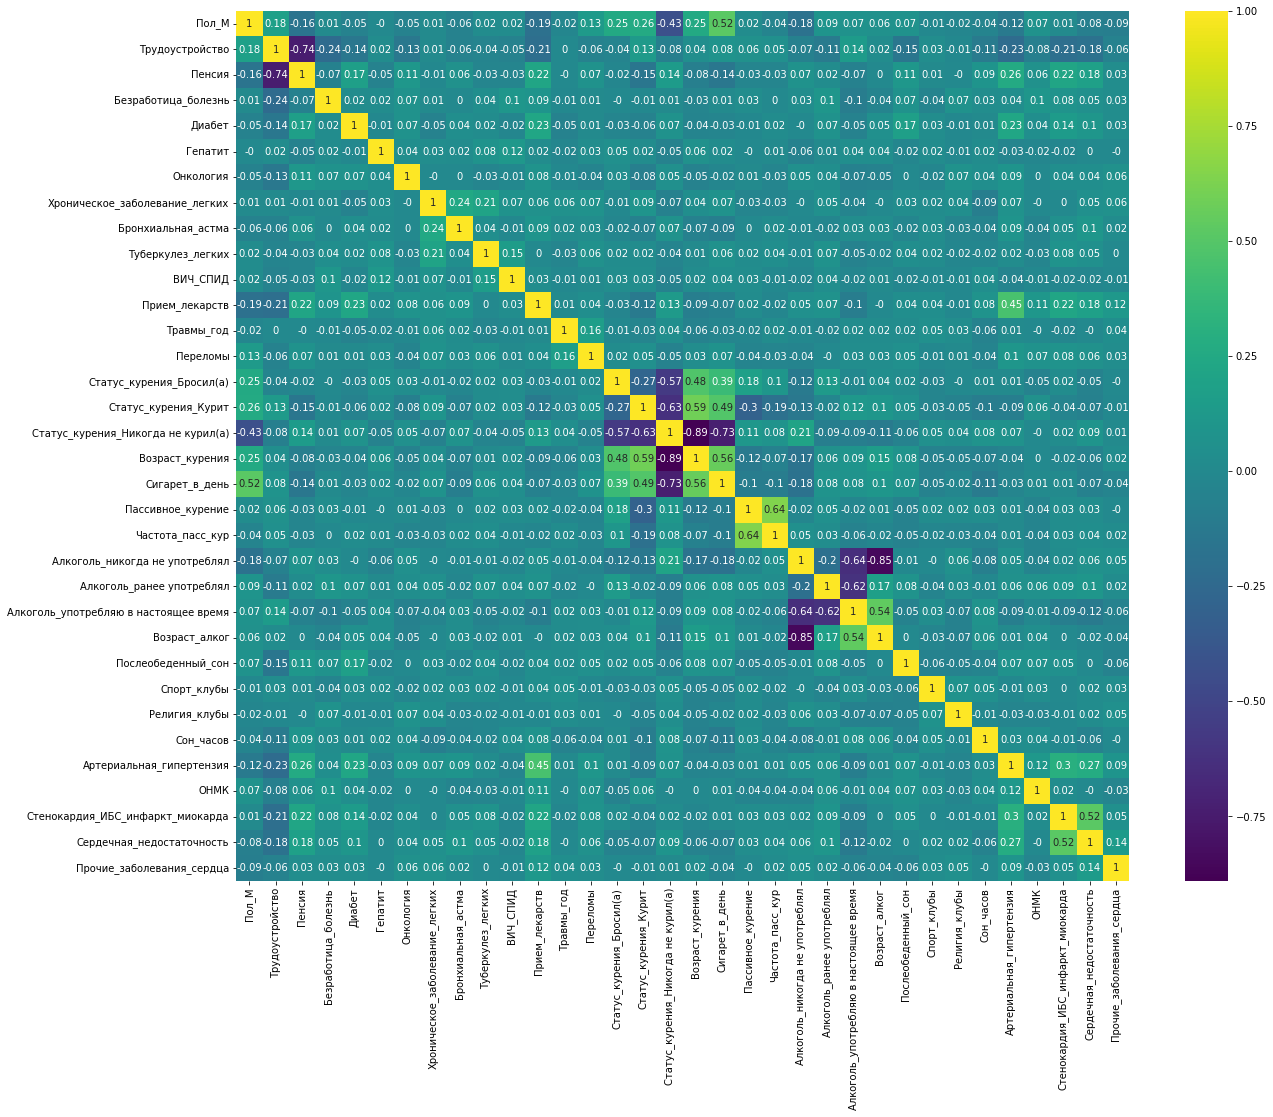

In [98]:
# корреляция признаков
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr().round(2), annot=True, cmap='viridis')

In [99]:
# анализ сбалансированности классов
for i in range(5):
    print(source_df[cell[i]].value_counts())

0    507
1    446
Name: Артериальная_гипертензия, dtype: int64
0    912
1     41
Name: ОНМК, dtype: int64
0    836
1    117
Name: Стенокардия_ИБС_инфаркт_миокарда, dtype: int64
0    857
1     96
Name: Сердечная_недостаточность, dtype: int64
0    867
1     86
Name: Прочие_заболевания_сердца, dtype: int64


*Первый target (Артериальная_гипертензия) сбалансирован. Остальные нет. Поэтому нужно использовать модели с параметрами балансировки классов, либо принимать меры для устранения дисбаланса классов. В противном случае модель может некорректно обучиться*

**Создадим функции для обучения модели (с выводом нужной метрики и прочих данных для сравнения), для возвращения обученной модели, для отбора признаков**

In [100]:
# для обучения модели + вывод информации о кроссвалидации
def train_with_stratifield(model, df, target, n_splits=5, random_state=None, shuffle=False, threshold=None, feat_sel=False):
    X = df.drop(cell, axis=1)
    if feat_sel:
        X = X[feat_sel]
    y = df[target]

    cvs_0 = list()
    cvs_1 = list()
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(X_train, y_train)
        if threshold:
            y_pred = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
        else:
            y_pred = model.predict(X_test)
        
        f1_0, f1_1 = f1_score(y_test, y_pred, average=None).round(2)
        cvs_0.append(f1_0)
        cvs_1.append(f1_1)
    print('all:', cvs_0, '\n    ', cvs_1)
    print('mean:', round(np.mean(cvs_0), 2), round(np.mean(cvs_1), 2))
    print('max:', np.max(cvs_0), np.max(cvs_1))
    print('min:', np.min(cvs_0), np.min(cvs_1))


In [101]:
# возвращает обученную модель 
def get_train_model(model, df, target, feat_sel=False):
    X_train = df.drop(cell, axis=1)
    if feat_sel:
        X_train = X_train[feat_sel]
    y_train = df[target]
    
    model_m = model
    model_m.fit(X_train, y_train)
    return model_m

In [102]:
# отбор признаков
def feature_selection_auto(estimator, X, y, min_features_to_select=2):
   
    rfecv = RFECV(estimator=estimator,
                  step=1,
                  cv=StratifiedKFold(5),
                  scoring="f1",
                  min_features_to_select=min_features_to_select)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (metric)")
    plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
    plt.show()
    
    names = list()
    for rank, name in zip(rfecv.ranking_, rfecv.feature_names_in_):
        if rank == 1:
            names.append(name)
    print(names)

*Отберем признаки для использования в модели (т.к. для каждой болезни будет своя модель, то признаки для каждой модели будут разными*. *Далее представлены отбор и обучение модели уже на конкретных алгоритмах, которые показали наиболее приемлемые результаты по итогам сравнения*

Optimal number of features : 2


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


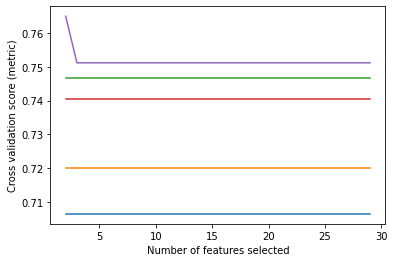

['ВИЧ_СПИД', 'Прием_лекарств']


In [103]:
# отбор признаков для первой болезни
feature_selection_auto(SVC(kernel='linear', class_weight='balanced'), df.drop(cell, axis=1), df[cell[0]])

In [104]:
# фиксирование признаков для первой болезни в отдельный список и дальнейшее обучение модели
feat_sel_ag = ['ВИЧ_СПИД', 'Прием_лекарств']
train_with_stratifield(SVC(kernel='linear', class_weight='balanced'), df, cell[0], feat_sel=feat_sel_ag)

all: [0.61, 0.69, 0.67, 0.69, 0.69] 
     [0.71, 0.72, 0.75, 0.74, 0.76]
mean: 0.67 0.74
max: 0.69 0.76
min: 0.61 0.71


Optimal number of features : 8


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


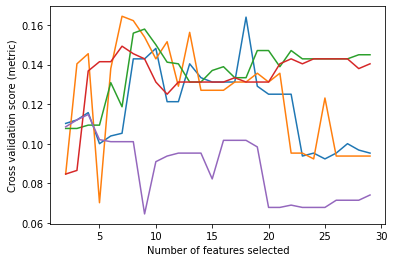

['Пол_М', 'Трудоустройство', 'Безработица_болезнь', 'Бронхиальная_астма', 'Туберкулез_легких', 'Прием_лекарств', 'Статус_курения_Бросил(а)', 'Религия_клубы']


In [105]:
# отбор признаков для второй болезни
feature_selection_auto(LogisticRegression(class_weight='balanced', max_iter=600), df.drop(cell, axis=1), df[cell[1]])

In [106]:
# фиксирование признаков для второй болезни в отдельный список и дальнейшее обучение модели
feat_sel_onmk = ['Трудоустройство', 'Безработица_болезнь', 'Бронхиальная_астма', 'Туберкулез_легких',
                 'Прием_лекарств', 'Религия_клубы', 'Пол_М', 'Статус_курения_Бросил(а)']
train_with_stratifield(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[1], feat_sel=feat_sel_onmk)

all: [0.79, 0.8, 0.79, 0.82, 0.82] 
     [0.16, 0.16, 0.16, 0.15, 0.15]
mean: 0.8 0.16
max: 0.82 0.16
min: 0.79 0.15


Optimal number of features : 11


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


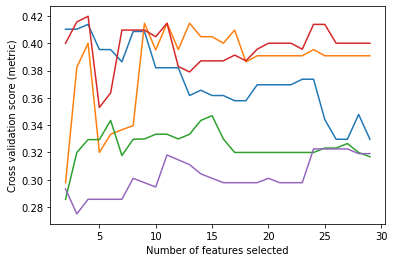

['Пол_М', 'Пенсия', 'Безработица_болезнь', 'Диабет', 'Онкология', 'Туберкулез_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 'Травмы_год', 'Переломы', 'Алкоголь_употребляю в настоящее время']


In [107]:
# отбор признаков для третьей болезни
feature_selection_auto(LogisticRegression(class_weight='balanced', max_iter=500), df.drop(cell, axis=1), df[cell[2]])

In [108]:
# фиксирование признаков для третьей болезни в отдельный список и дальнейшее обучение модели
feat_sel_sibsim = ['Пенсия', 'Безработица_болезнь', 'Диабет', 'Онкология', 'Туберкулез_легких', 'ВИЧ_СПИД', 
                   'Прием_лекарств', 'Травмы_год', 'Переломы', 'Пол_М', 'Алкоголь_употребляю в настоящее время']
train_with_stratifield(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[2], feat_sel=feat_sel_sibsim)

all: [0.8, 0.83, 0.78, 0.79, 0.79] 
     [0.41, 0.42, 0.33, 0.38, 0.31]
mean: 0.8 0.37
max: 0.83 0.42
min: 0.78 0.31


Optimal number of features : 29


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


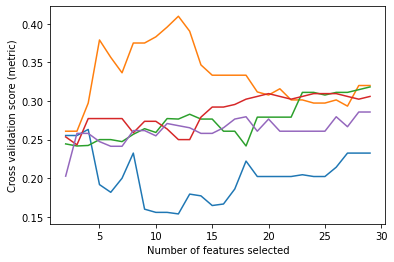

['Пол_М', 'Трудоустройство', 'Пенсия', 'Безработица_болезнь', 'Диабет', 'Гепатит', 'Онкология', 'Хроническое_заболевание_легких', 'Бронхиальная_астма', 'Туберкулез_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 'Травмы_год', 'Переломы', 'Статус_курения_Бросил(а)', 'Статус_курения_Курит', 'Статус_курения_Никогда не курил(а)', 'Возраст_курения', 'Сигарет_в_день', 'Пассивное_курение', 'Частота_пасс_кур', 'Алкоголь_никогда не употреблял', 'Алкоголь_ранее употреблял', 'Алкоголь_употребляю в настоящее время', 'Возраст_алког', 'Послеобеденный_сон', 'Спорт_клубы', 'Религия_клубы', 'Сон_часов']


In [109]:
# отбор признаков для четвертой болезни
feature_selection_auto(LogisticRegression(class_weight='balanced', max_iter=500), df.drop(cell, axis=1), df[cell[3]])

In [110]:
# фиксирование признаков для четвертой болезни в отдельный список и дальнейшее обучение модели
feat_sel_sn = ['Трудоустройство', 'Пенсия', 'Безработица_болезнь', 'Диабет', 'Онкология', 'Хроническое_заболевание_легких', 
               'Бронхиальная_астма', 'Туберкулез_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 'Травмы_год', 'Переломы', 
               'Сигарет_в_день', 'Пассивное_курение', 'Частота_пасс_кур', 'Возраст_алког', 'Послеобеденный_сон', 'Спорт_клубы',
               'Религия_клубы', 'Сон_часов', 'Пол_М', 'Статус_курения_Бросил(а)', 'Статус_курения_Курит', 
               'Статус_курения_Никогда не курил(а)', 'Алкоголь_никогда не употреблял', 'Алкоголь_ранее употреблял', 
               'Алкоголь_употребляю в настоящее время']
train_with_stratifield(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[3], feat_sel=feat_sel_sn)

all: [0.78, 0.84, 0.79, 0.8, 0.77] 
     [0.24, 0.31, 0.31, 0.31, 0.3]
mean: 0.8 0.29
max: 0.84 0.31
min: 0.77 0.24


Optimal number of features : 7


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


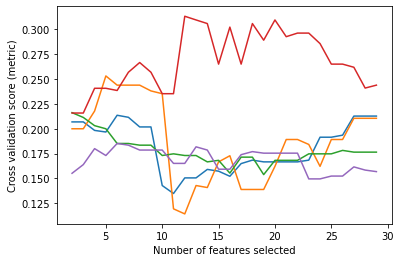

['Пол_М', 'Онкология', 'Хроническое_заболевание_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 'Послеобеденный_сон', 'Религия_клубы']


In [111]:
# отбор признаков для пятой болезни
feature_selection_auto(LogisticRegression(class_weight='balanced', max_iter=500), df.drop(cell, axis=1), df[cell[4]])

In [112]:
# фиксирование признаков для пятой болезни в отдельный список и дальнейшее обучение модели
feat_sel_pzs = ['Онкология', 'Хроническое_заболевание_легких', 'ВИЧ_СПИД', 'Прием_лекарств', 'Послеобеденный_сон', 
                'Религия_клубы', 'Пол_М']
train_with_stratifield(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[4], feat_sel=feat_sel_pzs)

all: [0.71, 0.81, 0.68, 0.78, 0.69] 
     [0.23, 0.29, 0.19, 0.29, 0.19]
mean: 0.73 0.24
max: 0.81 0.29
min: 0.68 0.19


*Обучение моделей на данных*

In [113]:
model_1 = get_train_model(SVC(kernel='linear', class_weight='balanced'), df, cell[0], feat_sel_ag)
model_2 = get_train_model(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[1], feat_sel=feat_sel_onmk)
model_3 = get_train_model(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[2], feat_sel=feat_sel_sibsim)
model_4 = get_train_model(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[3], feat_sel=feat_sel_sn)
model_5 = get_train_model(LogisticRegression(class_weight='balanced', max_iter=500), df, cell[4], feat_sel=feat_sel_pzs)

*Т.к. разбили на 5 независимых моделей (по одной на каждую болезнь), то для получения полного решения нужно сделать 5 списков с прогнозами (для каждой болезни свой) и объединить их в DataFrame*

In [114]:
# создадим списки с прогнозами для каждой болезни (для дальнейшей выгрузки в DataFrame и отправки)
list_1 = model_1.predict(test_df[feat_sel_ag])
list_2 = model_2.predict(test_df[feat_sel_onmk])
list_3 = model_3.predict(test_df[feat_sel_sibsim])
list_4 = model_4.predict(test_df[feat_sel_sn])
list_5 = model_5.predict(test_df[feat_sel_pzs])

In [115]:
d = {'ID': test_df['ID'], 
     'Артериальная гипертензия': list_1, 
     'ОНМК': list_2, 
     'Стенокардия, ИБС, инфаркт миокарда': list_3, 
     'Сердечная недостаточность': list_4, 
     'Прочие заболевания сердца': list_5}

df_output = pd.DataFrame(data=d)

In [116]:
df_output.to_csv("submission.csv", index=False)